In [1]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import json
from plotly import graph_objects as go
import matplotlib.pyplot as plt 
from plotly import express as px
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, SparseCategoricalAccuracy
tf.__version__
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

In [2]:
tf.keras.utils.get_file("/content/cifar10.zip",
                        origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip",
                        extract=True,
                        cache_subdir="/content")

In [2]:
df = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")

In [3]:
df["id"] = df["id"].apply(lambda x : f"{x}.png")

In [4]:
df

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile
...,...,...
49995,49996.png,bird
49996,49997.png,frog
49997,49998.png,truck
49998,49999.png,automobile


In [5]:
img = tf.io.read_file('/content/train/1.png')
img = tf.image.decode_jpeg(img)
px.imshow(img)

In [6]:
a = df.drop_duplicates(subset="label")
a

,id,label
0,1.png,frog
1,2.png,truck
3,4.png,deer
4,5.png,automobile
6,7.png,bird
7,8.png,horse
8,9.png,ship
9,10.png,cat
27,28.png,dog
29,30.png,airplane


C:\Users\jerem\AppData\Local\Temp\ipykernel_23412\1421141306.py:10: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



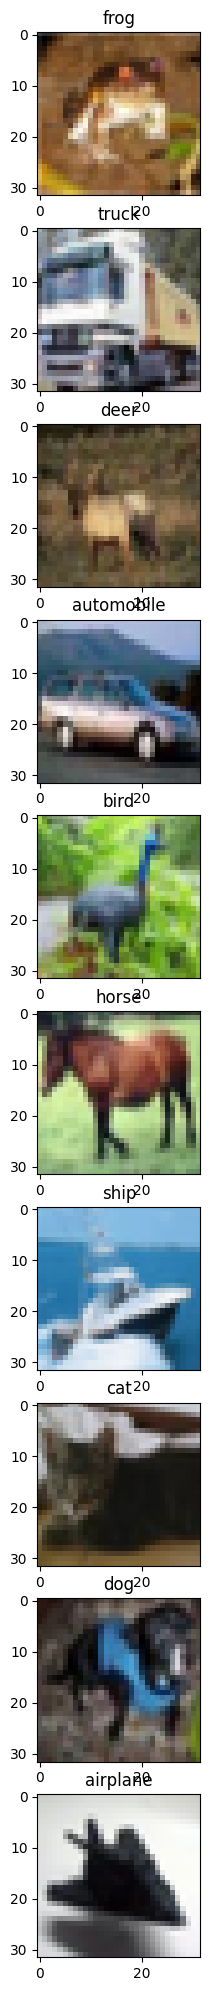

In [7]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(15,25))
i = 0
for id , label in zip(a.id, a.label):
    path = f"/content/train/{id}"
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    ax[i].imshow(img)
    ax[i].title.set_text(label)
    i += 1
fig.show()

In [11]:
img_generator = ImageDataGenerator(
    rescale=1/255., 
    fill_mode='wrap',
    validation_split=0.3
)

In [12]:
df_generator = img_generator.flow_from_dataframe(
    dataframe=df,
    directory="/content/train", 
    x_col="id", 
    y_col="label", 
    target_size=(32,32),
    class_mode = "sparse", 
    batch_size=64, 
    shuffle = True,  
    subset = "training"
)

validation_generator = img_generator.flow_from_dataframe(
    dataframe=df,
    directory="content/train", 
    x_col="id", 
    y_col="label", 
    target_size=(32,32),
    class_mode = "sparse", 
    batch_size=64, 
    shuffle = True,  
    subset = "validation"
)



Found 35000 validated image filenames belonging to 10 classes.
Found 15000 validated image filenames belonging to 10 classes.


In [13]:
# imgs, targets = next(iter(df_generator))
# fig, ax = plt.subplots(8,2, figsize=(10,40))
# for i, (img, target) in enumerate(zip(imgs, targets)):
#   ax[i-8*(i//8),i//8].imshow(img)
#   ax[i-8*(i//8),i//8].title.set_text(str(target))
# fig.show()

In [14]:
imgs, targets = next(iter(df_generator))

modelconv = tf.keras.Sequential(
    [
    Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) # the input shape (height, width, channels)
     ),
    MaxPool2D(pool_size=2, # the size of the pooling window
            strides=2),
    tf.keras.layers.Flatten(), # this layer turns multi-dimensional images into flat objects
    tf.keras.layers.Dense(10, activation="softmax")
    ]
)

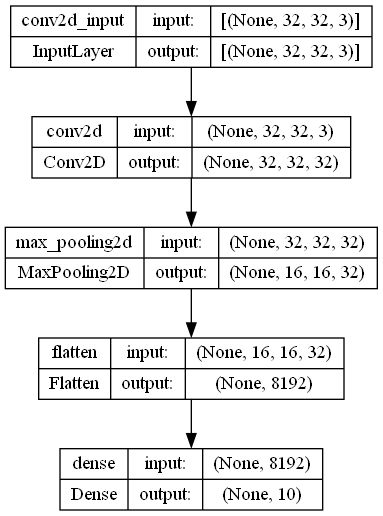

In [15]:
tf.keras.utils.plot_model(modelconv, show_shapes=True)

In [16]:
modelconv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                                 
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [17]:
modelconv.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [18]:
modelconv.fit(df_generator, epochs = 50, validation_data=validation_generator)

Epoch 1/50
547/547 [==============================] - 25s 44ms/step - loss: 1.6009 - sparse_categorical_accuracy: 0.4420 - val_loss: 1.3520 - val_sparse_categorical_accuracy: 0.5304
Epoch 2/50
547/547 [==============================] - 17s 31ms/step - loss: 1.2881 - sparse_categorical_accuracy: 0.5535 - val_loss: 1.2500 - val_sparse_categorical_accuracy: 0.5609
Epoch 3/50
547/547 [==============================] - 17s 30ms/step - loss: 1.1850 - sparse_categorical_accuracy: 0.5894 - val_loss: 1.2282 - val_sparse_categorical_accuracy: 0.5685
Epoch 4/50
547/547 [==============================] - 16s 29ms/step - loss: 1.1191 - sparse_categorical_accuracy: 0.6178 - val_loss: 1.1908 - val_sparse_categorical_accuracy: 0.5835
Epoch 5/50
547/547 [==============================] - 16s 29ms/step - loss: 1.0640 - sparse_categorical_accuracy: 0.6353 - val_loss: 1.1662 - val_sparse_categorical_accuracy: 0.5971
Epoch 6/50
547/547 [==============================] - 16s 29ms/step - loss: 1.0190 - spars

In [19]:
modelconv.save("cifar10model1conv.h5")

In [20]:
history_dict = modelconv.history.history
json.dump(history_dict, open("cifar10model1convhistory.json", 'w'))

In [21]:
model = pd.read_json("cifar10model1convhistory.json")

In [22]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=model["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=model["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [23]:
imgs, targets = next(iter(df_generator))

model_2 = tf.keras.Sequential(
    [
    Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(10, activation="softmax")
    ]
)

In [24]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [25]:
model_2.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [26]:
model_2.fit(df_generator, epochs = 50, validation_data=validation_generator)

Epoch 1/50
547/547 [==============================] - 21s 38ms/step - loss: 1.5593 - sparse_categorical_accuracy: 0.4441 - val_loss: 1.3018 - val_sparse_categorical_accuracy: 0.5469
Epoch 2/50
547/547 [==============================] - 21s 38ms/step - loss: 1.2076 - sparse_categorical_accuracy: 0.5805 - val_loss: 1.1276 - val_sparse_categorical_accuracy: 0.5979
Epoch 3/50
547/547 [==============================] - 21s 38ms/step - loss: 1.0617 - sparse_categorical_accuracy: 0.6294 - val_loss: 1.0425 - val_sparse_categorical_accuracy: 0.6371
Epoch 4/50
547/547 [==============================] - 21s 38ms/step - loss: 0.9649 - sparse_categorical_accuracy: 0.6685 - val_loss: 0.9901 - val_sparse_categorical_accuracy: 0.6565
Epoch 5/50
547/547 [==============================] - 20s 37ms/step - loss: 0.8893 - sparse_categorical_accuracy: 0.6944 - val_loss: 0.9861 - val_sparse_categorical_accuracy: 0.6563
Epoch 6/50
547/547 [==============================] - 21s 38ms/step - loss: 0.8341 - spars

In [27]:
model_2.save("cifar10model2conv.h5")

In [28]:
history_dict = model_2.history.history
json.dump(history_dict, open("cifar10model2convhistory.json", 'w'))

In [29]:
model_2 = pd.read_json("cifar10model2convhistory.json")

In [30]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=model_2["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=model_2["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [31]:
imgs, targets = next(iter(df_generator))

model_3 = tf.keras.Sequential(
    [
    Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(10, activation="softmax")
    ]
)

In [32]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 128)       

In [33]:
model_3.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [34]:
model_3.fit(df_generator, epochs = 50, validation_data=validation_generator)

Epoch 1/50
547/547 [==============================] - 24s 44ms/step - loss: 1.5526 - sparse_categorical_accuracy: 0.4379 - val_loss: 1.3006 - val_sparse_categorical_accuracy: 0.5341
Epoch 2/50
547/547 [==============================] - 24s 43ms/step - loss: 1.1664 - sparse_categorical_accuracy: 0.5920 - val_loss: 1.0647 - val_sparse_categorical_accuracy: 0.6231
Epoch 3/50
547/547 [==============================] - 24s 43ms/step - loss: 0.9987 - sparse_categorical_accuracy: 0.6517 - val_loss: 0.9874 - val_sparse_categorical_accuracy: 0.6566
Epoch 4/50
547/547 [==============================] - 24s 43ms/step - loss: 0.8896 - sparse_categorical_accuracy: 0.6898 - val_loss: 0.9876 - val_sparse_categorical_accuracy: 0.6581
Epoch 5/50
547/547 [==============================] - 24s 43ms/step - loss: 0.8041 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.9799 - val_sparse_categorical_accuracy: 0.6593
Epoch 6/50
547/547 [==============================] - 24s 44ms/step - loss: 0.7380 - spars

In [35]:
model_3.save("cifar10model3conv.h5")

In [36]:
history_dict = model_3.history.history
json.dump(history_dict, open("cifar10model3convhistory.json", 'w'))

In [37]:
model_3 = pd.read_json("cifar10model3convhistory.json")

In [38]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=model_3["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=model_3["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [39]:
imgs, targets = next(iter(df_generator))

model_4 = tf.keras.Sequential(
    [
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 256,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(10, activation="softmax")
    ]
)

In [40]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 256)       

In [41]:
model_4.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [42]:
model_4.fit(df_generator, epochs = 50, validation_data=validation_generator)

Epoch 1/50
547/547 [==============================] - 44s 80ms/step - loss: 1.5231 - sparse_categorical_accuracy: 0.4529 - val_loss: 1.2171 - val_sparse_categorical_accuracy: 0.5673
Epoch 2/50
547/547 [==============================] - 43s 79ms/step - loss: 1.0582 - sparse_categorical_accuracy: 0.6303 - val_loss: 0.9777 - val_sparse_categorical_accuracy: 0.6617
Epoch 3/50
547/547 [==============================] - 44s 80ms/step - loss: 0.8566 - sparse_categorical_accuracy: 0.7047 - val_loss: 0.8583 - val_sparse_categorical_accuracy: 0.6977
Epoch 4/50
547/547 [==============================] - 44s 81ms/step - loss: 0.7336 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.8502 - val_sparse_categorical_accuracy: 0.7049
Epoch 5/50
547/547 [==============================] - 44s 81ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.8131 - val_sparse_categorical_accuracy: 0.7217
Epoch 6/50
547/547 [==============================] - 44s 80ms/step - loss: 0.5386 - spars

In [43]:
model_4.save("cifar10model4conv.h5")

In [44]:
history_dict = model_4.history.history
json.dump(history_dict, open("cifar10model4convhistory.json", 'w'))

In [45]:
model_4 = pd.read_json("cifar10model4convhistory.json")

In [46]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=model_4["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=model_4["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [47]:
imgs, targets = next(iter(df_generator))

model_5 = tf.keras.Sequential(
    [
    Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    Conv2D(
        filters = 32,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    Conv2D(
        filters = 64,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    Conv2D(
        filters = 128,
        kernel_size = (3,3),
        strides = 1,
        padding = "same",
        activation = "relu",
        input_shape = (imgs.shape[1], imgs.shape[2], imgs.shape[3]) 
     ),
    MaxPool2D(
        pool_size=2, 
        strides=2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(10, activation="softmax")
    ]
)

In [48]:
model_5.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [49]:
model_5.fit(df_generator, epochs = 50, validation_data=validation_generator)

Epoch 1/50
547/547 [==============================] - 61s 111ms/step - loss: 1.5994 - sparse_categorical_accuracy: 0.4122 - val_loss: 1.3612 - val_sparse_categorical_accuracy: 0.4961
Epoch 2/50
547/547 [==============================] - 61s 111ms/step - loss: 1.0954 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.6535
Epoch 3/50
547/547 [==============================] - 62s 113ms/step - loss: 0.8687 - sparse_categorical_accuracy: 0.6952 - val_loss: 0.8978 - val_sparse_categorical_accuracy: 0.6879
Epoch 4/50
547/547 [==============================] - 60s 109ms/step - loss: 0.7262 - sparse_categorical_accuracy: 0.7447 - val_loss: 0.7692 - val_sparse_categorical_accuracy: 0.7327
Epoch 5/50
547/547 [==============================] - 61s 111ms/step - loss: 0.6148 - sparse_categorical_accuracy: 0.7859 - val_loss: 0.7321 - val_sparse_categorical_accuracy: 0.7426
Epoch 6/50
547/547 [==============================] - 61s 112ms/step - loss: 0.5144 -

In [50]:
model_5.save("cifar10model5conv.h5")

In [51]:
history_dict = model_5.history.history
json.dump(history_dict, open("cifar10model5convhistory.json", 'w'))

In [52]:
model_5 = pd.read_json("cifar10model5convhistory.json")

In [53]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=model_5["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=model_5["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()